In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
#from sklearn.model_selection import cross_val_score
from sklearn.cluster import KMeans
from sklearn import preprocessing
from sklearn import linear_model 
from sklearn import metrics 
from sklearn.feature_selection import RFECV 
from sklearn.svm import SVR 
import pickle
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_val_score

In [12]:
#Select the Store and Version of Clustered Data
Store = 160
w = ['Monday', 'Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'] 
data = pd.read_csv('Store'+str(Store)+'\Store'+str(Store)+'_order_15-min-cluster_20180103-20190711.csv',index_col=0)

data['BusinessDate'] = pd.to_datetime(data['BusinessDate'])
#Specify Date-Time Variable Types
date_time = ['OrderStartDateTime','NormalDateTime','BumpedDateTime','CookingDateTime','DayHalfHour','DayQuarterHour']
for i in date_time:
    data.loc[:,i] = pd.to_datetime(data.loc[:,i], format="%Y-%m-%d %H:%M:%S.%f")
    
OperatingHour = pd.read_excel('Operating Hours.xlsx',sheet_name=str(Store),index_col=0)

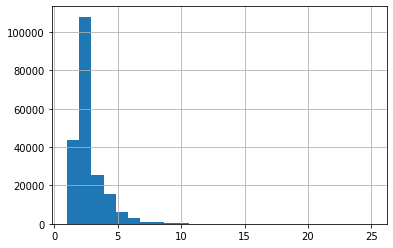

In [13]:
#Show On-Premise Party Size distribution
data[data['TypeofServiceNum']==0]['GuestCount'].hist(bins=25)

In [14]:
#Show On-Premise Party Size distribution
data[data['TypeofServiceNum']==0]['GuestCount'].value_counts() / data[data['TypeofServiceNum']==0].shape[0]

2.0     0.525530
1.0     0.213513
3.0     0.124454
4.0     0.075739
5.0     0.030530
6.0     0.014284
7.0     0.005433
8.0     0.004596
9.0     0.001811
10.0    0.001675
12.0    0.000633
11.0    0.000545
20.0    0.000409
13.0    0.000248
14.0    0.000190
15.0    0.000166
16.0    0.000141
18.0    0.000058
19.0    0.000015
17.0    0.000015
25.0    0.000010
23.0    0.000005
Name: GuestCount, dtype: float64

In [15]:
Station = pd.Series(data['StationName'].unique()).str.lower()

In [ ]:
#Make sure to run this when using Punch Data as the source of Labor at Station
#Check in labor_st contains names of labor at staions
labor_st = list(data.columns[63:])

In [16]:
# Aggregate to 90% percentile
data = data.groupby(['StoreKey','BusinessDate','DayOfWeek','Holiday','Hour','QuarterHour','Class','GuestCount','StartTime'])['OrderTime'].agg(lambda x: np.percentile(x,q=90)).reset_index()

In [17]:
# Agregate to Mean
#data = data[data['TypeofServiceNum']==0].groupby(['StoreKey','BusinessDate','DayOfWeek','Holiday','Hour','QuarterHour','Class','GuestCount','StartTime'])['OrderTime'].mean().reset_index()

In [18]:
data.columns

Index(['StoreKey', 'BusinessDate', 'DayOfWeek', 'Holiday', 'Hour',
       'QuarterHour', 'Class', 'GuestCount', 'StartTime', 'OrderTime'],
      dtype='object')

In [19]:
data.shape

(94382, 10)

In [20]:
OperatingHour

,Open,Close
Monday,11,23.5
Tuesday,11,23.5
Wednesday,11,23.5
Thursday,11,23.5
Friday,11,26.0
Saturday,10,26.0
Sunday,10,23.5


In [21]:
#Read in #Items, #Orders for every 15-minute period
Day_Time1 = pd.read_csv('Store'+str(Store)+'\Store'+str(Store)+'_day-15min.csv',index_col=0)
Day_Time1['BusinessDate'] = pd.to_datetime(Day_Time1['BusinessDate'])
Day_Time1['DayQuarterHour'] = pd.to_datetime(Day_Time1['DayQuarterHour'])
Day_Time1['DayQuarterHourEnd'] = pd.to_datetime(Day_Time1['DayQuarterHourEnd'])

#Identify day of week: 0 represents Mon, 6 represents Sun 
Day_Time1['DayOfWeek'] = Day_Time1['BusinessDate'].dt.weekday
Day_Time1['DayOfWeekName'] = Day_Time1['BusinessDate'].dt.weekday_name
Day_Time1['Week'] = Day_Time1['BusinessDate'].dt.week

#Create Label for whole hour (for graphing)
Day_Time1['Label1'] = Day_Time1['QuarterHour'].apply(lambda x: x.is_integer())
Day_Time1['Label2'] = Day_Time1['QuarterHour'].apply(lambda x: (x/2).is_integer()) 
Day_Time1['Label1'] = np.where(Day_Time1['QuarterHour']==24,False,Day_Time1['Label1'])
Day_Time1['Label2'] = np.where(Day_Time1['QuarterHour']==24,False,Day_Time1['Label2'])

#Calculate Total Item and Total Order
Day_Time1['TotalItem']=Day_Time1['OnSiteItem']+Day_Time1['OffSiteItem']
Day_Time1['TotalOrder']=Day_Time1['OnSiteOrder']+Day_Time1['OffSiteOrder']

# Remove Times Out of Operating Time
d=pd.DataFrame()
for i in w:
    d = d.append(Day_Time1[((Day_Time1['DayOfWeekName']==i)&(Day_Time1['QuarterHour']>=OperatingHour.loc[i,'Open'])&(Day_Time1['QuarterHour']<OperatingHour.loc[i,'Close']))])
Day_Time1 = d
del d

In [22]:
#Merge #Item, #Order into aggregated Order Time
data = data.merge(right=Day_Time1.drop_duplicates(subset=['BusinessDate','QuarterHour'])[['BusinessDate','QuarterHour','OnSiteOrder','OffSiteOrder','TotalOrder','OnSiteItem','OffSiteItem','TotalItem','OnSiteGuest','DayOfWeekName']],how='left',on=['BusinessDate','QuarterHour'])

# Visualization by Variable

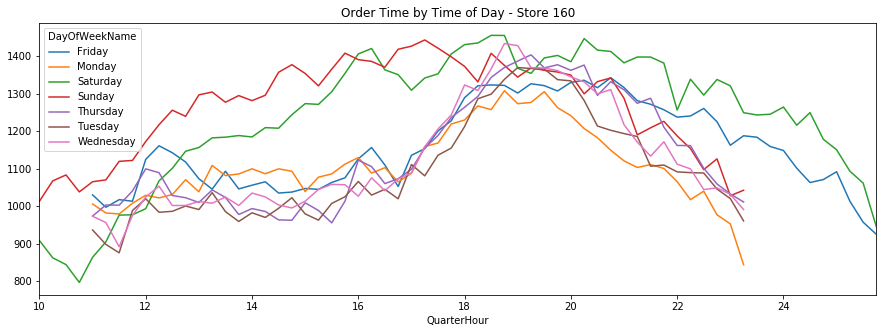

In [23]:
#Order Time by Day of Week & Time of Day (15 min)
data.groupby(['QuarterHour','DayOfWeekName'])['OrderTime'].mean().unstack().plot(kind='line',legend='True',figsize=(15,5),title='Order Time by Time of Day - Store '+str(Store)) 

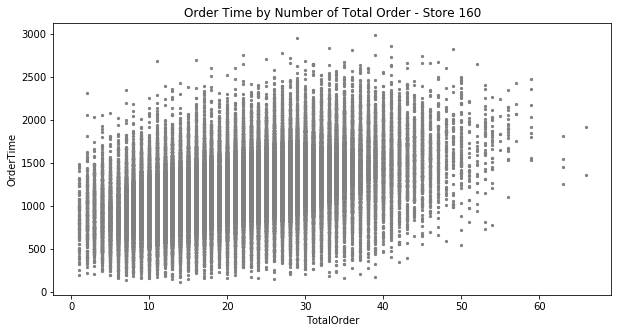

In [24]:
#Order Time by Total Order
data.plot(x='TotalOrder', y='OrderTime', kind='scatter',figsize=(10,5),title='Order Time by Number of Total Order - Store '+str(Store),c='grey',s=5)
#data.groupby(['TotalOrder'])['OrderTime'].mean().plot(linewidth=4)

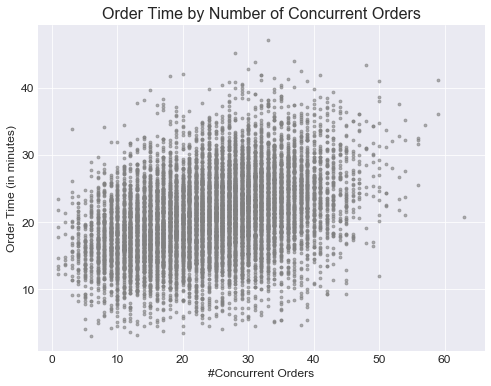

In [25]:
#Order Time by Total Order with selected party size
plt.style.use('seaborn-dark')

#Input Party Size
p=4


plt.figure(figsize=(8,6))
data['OrderTime-Min'] = data['OrderTime']/60
plt.scatter(data[(data['GuestCount']==p)]['TotalOrder'], data[(data['GuestCount']==p)]['OrderTime-Min'],c='grey',s=8,alpha=0.6)
plt.title('Order Time by Number of Concurrent Orders',fontsize=16)
plt.xlabel('#Concurrent Orders',fontsize=12)
plt.ylabel('Order Time (in minutes)',fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
#plt.ylim(-2,55)
#plt.xlim(-5,70)
plt.grid()

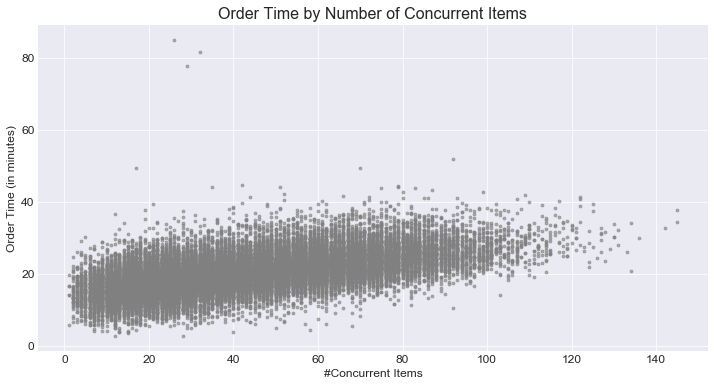

In [16]:
#Order Time by Total Item with selected party size
plt.style.use('seaborn-dark')

#Input party size
p=2

plt.figure(figsize=(12,6))
data['OrderTime-Min'] = data['OrderTime']/60
plt.scatter(data[(data['GuestCount']==p)]['TotalItem'], data[(data['GuestCount']==p)]['OrderTime-Min'],c='grey',s=8,alpha=0.6)
plt.title('Order Time by Number of Concurrent Items',fontsize=16)
plt.xlabel('#Concurrent Items',fontsize=12)
plt.ylabel('Order Time (in minutes)',fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
#plt.ylim(-2,55)
#plt.xlim(-5,70)
plt.grid()

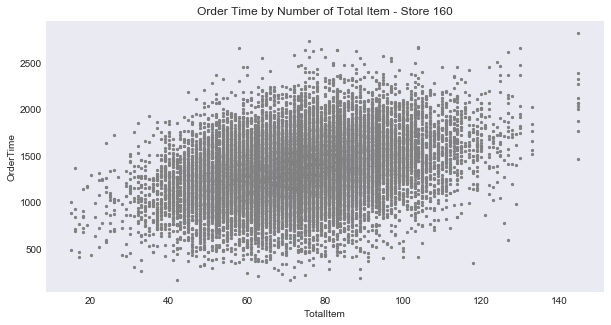

In [17]:
#Order Time by Total Item during the Bussiest Time
#Input day-time cluster number: 0 represents the bussiest
c=0
data[data['Class']==c].plot(x='TotalItem', y='OrderTime', kind='scatter',figsize=(10,5),title='Order Time by Number of Total Item - Store '+str(Store),c='grey',s=5)

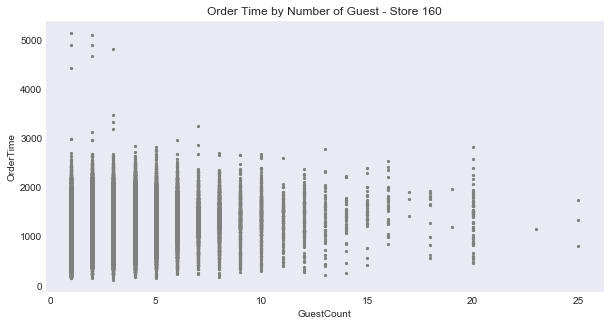

In [21]:
#Order Time by Number of Guest
data.plot(x='GuestCount', y='OrderTime', kind='scatter',figsize=(10,5),title='Order Time by Number of Guest - Store '+str(Store),c='grey',s=5)

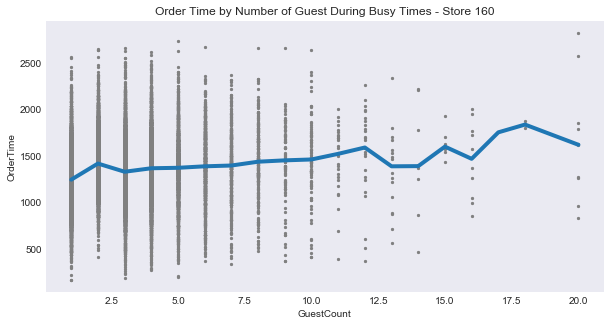

In [20]:
#Order Time by Number of Guest during the Bussiest Time
#Select time cluster number: 0 represents the bussiest
c=0
data[data['Class']==c].plot(x='GuestCount', y='OrderTime', kind='scatter',figsize=(10,5),title='Order Time by Number of Guest During Busy Times - Store '+str(Store),c='grey',s=5)
data[data['Class']==c].groupby(['GuestCount'])['OrderTime'].agg(lambda x: np.percentile(x,q=50)).plot(linewidth=4)

# Merge Labor Variable

## Labor by Category

In [26]:
labor = pd.read_csv('labor_20180103-20190711.csv')
labor = labor[labor['StoreKey']==Store]
#Specify Variable Type for Date Time Variables
labor.loc[:,'BusinessDate'] = pd.to_datetime(labor.loc[:,'BusinessDate'])

#Clean Hour Description
labor['Hour'] = np.where(labor['HourDescription'].str.contains('PM'), labor['HourDescription'].str.slice(0,2).str.replace(' ','').astype('int')+12, labor['HourDescription'].str.slice(0,2).str.replace(' ','').astype('int'))
labor['Hour'] = np.where(labor['Hour']==12,0,labor['Hour'])
labor['Hour'] = np.where(labor['Hour']==24,12,labor['Hour'])
labor.columns= ['BusinessDate','StoreKey', 'LaborCategory','HourDescription','ActualLaborHrs','Hour']
labor.head()

,BusinessDate,StoreKey,LaborCategory,HourDescription,ActualLaborHrs,Hour
29037,2018-06-26,160,Prep,1 AM,0.38,1
29038,2018-06-26,160,Dishwasher,1 AM,0.65,1
29039,2018-06-26,160,Bar,1 AM,0.52,1
29040,2018-06-26,160,Busser,1 AM,1.22,1
29041,2018-06-26,160,Cook,1 PM,3.12,13


In [27]:
#Show all unique labor categories
labor['LaborCategory'].unique()

array(['Prep', 'Dishwasher', 'Bar', 'Busser', 'Cook', 'Front Desk',
       'Server', 'IT Serv', 'KM Support', 'OST', 'To Go', 'Bakery',
       'Runner', 'Steward', 'Napkin', 'IT Cook', 'IT FD', 'IT Bar',
       'IT Dish', 'IT Bus', 'Expo', 'IT Prep', 'Lead Trainer', 'IT Bake',
       'IT Steward', 'IT SAT', 'Management'], dtype=object)

In [28]:
#Keep selected labor categories
labor = labor[labor['LaborCategory'].isin(['Prep', 'Dishwasher', 'Busser', 'Cook', 'Front Desk',
       'Server', 'IT Serv', 'KM Support', 'OST', 'To Go', 
       'Runner', 'Steward', 'IT Cook', 'IT FD', 
       'IT Dish', 'IT Bus', 'Expo', 'IT Prep',
       'IT Steward', 'IT SAT', 'Management'])]

In [29]:
#Merge Each Labor Category into data
labor_cat = []
for i in labor['LaborCategory'].unique(): 
    r = labor[labor['LaborCategory'] == i][['StoreKey','BusinessDate','Hour','ActualLaborHrs']]
    r.columns = ['StoreKey','BusinessDate','Hour','LaborHrs_'+i]
    data = data.merge(right = r, how = 'left', on = ['StoreKey','BusinessDate','Hour'])
    data['LaborHrs_'+i] = np.where(pd.isna(data['LaborHrs_'+i]),0,data['LaborHrs_'+i])
    labor_cat.append('LaborHrs_'+i)

In [30]:
#Align date range from different data source
data=data[data['BusinessDate']>='2018-06-26']

## Labor at Station

In [32]:
#Employee & Minutes worked during any hour
labor1 = pd.read_csv('Store'+str(Store)+'\Store'+str(Store)+'_employee_labor_20180103-20190711.csv')
labor1['BusinessDate'] = pd.to_datetime(labor1['BusinessDate'])
labor1.head()

,BusinessDate,StoreKey,Hour,EmployeeKey,JobName,LaborCategoryName,ActualLaborMinutes
0,2018-06-26,160,7,63032,Prep Cook,Prep,40
1,2018-06-26,160,8,63032,Prep Cook,Prep,60
2,2018-06-26,160,9,63032,Prep Cook,Prep,60
3,2018-06-26,160,10,63032,Prep Cook,Prep,60
4,2018-06-26,160,11,63032,Prep Cook,Prep,60


In [31]:
#Employee & location scheduled on any day
schedule = pd.read_csv('employee_station_20180103-20190711.csv')
schedule = schedule[schedule['StoreKey']==Store]
schedule['BusinessDate'] = pd.to_datetime(schedule['BusinessDate'])
schedule['StartTime'] = pd.to_datetime(schedule['StartTime'])
schedule['EndTime'] = pd.to_datetime(schedule['EndTime'])
schedule['LocationName'] = schedule['LocationName'].str.lower()
schedule.head()

,BusinessDate,StoreKey,EmployeeKey,JobName,LaborCategoryName,StartTime,EndTime,LocationName
21475,2018-02-20,160,268579,Line Cook1,Cook,2018-02-20 09:00:00,2018-02-20 16:00:00,saladst
21476,2018-02-20,160,140930,Line Cook1,Cook,2018-02-20 09:00:00,2018-02-20 16:00:00,broilck
21477,2018-02-20,160,107746,Line Cook1,Cook,2018-02-20 09:00:00,2018-02-20 16:00:00,grillck
21478,2018-02-20,160,63897,Line Cook1,Cook,2018-02-20 09:00:00,2018-02-20 16:00:00,pizzast
21479,2018-02-20,160,169393,Line Cook1,Cook,2018-02-20 09:00:00,2018-02-20 16:00:00,fryck


In [34]:
s = [i.replace('broiler', 'broil') for i in Station]
s = [i.replace('sandwich', 'sand') for i in s]
s = [i.replace('apps', 'app') for i in s]
s_clean=s
s_sort = [i for i in s_clean if (' / ' not in i)] + [i for i in s_clean if (' / ' in i)]
schedule['AtStation'] = None
labor_st = []
for i in s_sort:
    name = 'Labor_'+str(i)
    labor_st.append(name)
    if ' / ' not in i: 
        schedule[name] = np.where(schedule['LocationName'].str.contains(i),1,0)
        schedule['AtStation'] = np.where(schedule['LocationName'].str.contains(i),1,schedule['AtStation'])
    elif ' / ' in i:  #if combo station, must contain key words from both station 
        i1,i2  = i.split(' / ')
        print(i1,i2)
        schedule[name] = np.where(((schedule['LocationName'].str.contains(i1))|(schedule['LocationName'].str.contains(i2)))&(pd.isnull(schedule['AtStation'])),1,0)
        schedule['AtStation'] = np.where(((schedule['LocationName'].str.contains(i1))|(schedule['LocationName'].str.contains(i2)))&(pd.isnull(schedule['AtStation'])),1,schedule['AtStation'])

broil app
grill fry
pasta saute


In [35]:
#Matched StationName - LocationName
station_location = {}
for i in s: 
    name = 'Labor_'+str(i)
    station_location[i] = schedule[schedule[name]==1]['LocationName'].unique()
station_location

{'saute': array(['sautest', 'sautepl', 'sautefl', 'sautemd'], dtype=object),
 'broil / app': array(['broilck', 'broilpl', 'broilmd'], dtype=object),
 'grill / fry': array(['grillck', 'grillpl'], dtype=object),
 'pasta / saute': array(['pastast', 'pastapl', 'pastafl', 'pastamd'], dtype=object),
 'salad': array(['saladst', 'saladpr', 'saladfn', 'saladmd'], dtype=object),
 'fry': array(['fryck', 'frypl'], dtype=object),
 'pizza': array(['pizzast', 'pizzafn'], dtype=object),
 'sand': array([], dtype=object)}

In [36]:
schedule['LocationName'].unique()

array(['saladst', 'broilck', 'grillck', 'pizzast', 'fryck', 'pastast',
       'sautest', 'scraping', 'racking', 'cleansd', 'potwash', 'fill1',
       'greet1', '.din 16', '.din 13', '.din 06', '.din 02', 'bar 01',
       '.din 09', '.din 04', '.din 14', 'bar 04', '.din 10', 'ost',
       'oven', 'saladpr', 'slicer', 'sauceck', 'prodrl', 'pprepcr',
       'cash1', 'dessert 1', 'crbcsh1', 'barcw1', 'busd01', 'busd05',
       'busd04', 'upfdrn1', 'portion', 'no_location', 'napkin1',
       'train cook', 'train fd', 'kitchfl', 'steward', 'strbar',
       '.din 15', 'bar 02', 'cash2', 'dessert 2', 'barcw2', 'barmw1',
       'busd03', 'busd02', 'fdrun2', 'frypl', 'pastapl', 'sautepl',
       'dsfloat', 'dskrun1', 'dskrun2', 'crowd1', '.din 11', '.din 07',
       '.din 05', '.din 08', '.din 17', '.din 12', 'bar 03', '.din 03',
       'fdrun3', 'fdrun5', 'fdrun4', 'carts', 'train bake', 'pprepfl',
       'train bus', 'bsrncpt', '.din 01', 'train bar', 'train server',
       'scrape', 'busb03',

In [37]:
#Uncategorized Location
list(schedule[pd.isnull(schedule['AtStation'])]['LocationName'].unique())

['scraping',
 'racking',
 'cleansd',
 'potwash',
 'fill1',
 'greet1',
 '.din 16',
 '.din 13',
 '.din 06',
 '.din 02',
 'bar 01',
 '.din 09',
 '.din 04',
 '.din 14',
 'bar 04',
 '.din 10',
 'ost',
 'oven',
 'slicer',
 'sauceck',
 'prodrl',
 'pprepcr',
 'cash1',
 'dessert 1',
 'crbcsh1',
 'barcw1',
 'busd01',
 'busd05',
 'busd04',
 'upfdrn1',
 'portion',
 'no_location',
 'napkin1',
 'train cook',
 'train fd',
 'kitchfl',
 'steward',
 'strbar',
 '.din 15',
 'bar 02',
 'cash2',
 'dessert 2',
 'barcw2',
 'barmw1',
 'busd03',
 'busd02',
 'fdrun2',
 'dsfloat',
 'dskrun1',
 'dskrun2',
 'crowd1',
 '.din 11',
 '.din 07',
 '.din 05',
 '.din 08',
 '.din 17',
 '.din 12',
 'bar 03',
 '.din 03',
 'fdrun3',
 'fdrun5',
 'fdrun4',
 'carts',
 'train bake',
 'pprepfl',
 'train bus',
 'bsrncpt',
 '.din 01',
 'train bar',
 'train server',
 'scrape',
 'busb03',
 'strbake',
 'upcrwd1',
 'train dish',
 'prodfl',
 'pat 01',
 'pat 02',
 'pat 03',
 'train prep',
 'upcarts',
 'do not use',
 'upgrt1',
 'busp01',
 '

In [ ]:
#Keep the relationship between Employee and Station
employee_station = schedule[pd.isnull(schedule['AtStation'])==False].drop(columns=['JobName','LaborCategoryName','StartTime','EndTime','LocationName'])

In [ ]:
labor2 = labor1.merge(right=employee_station, on=['StoreKey','EmployeeKey','BusinessDate']) 
labor2 = labor2.drop(columns='EmployeeKey').groupby(['StoreKey','BusinessDate','Hour']+labor_st).sum().reset_index()

#Fill in Hours worked at Station during the Hour period
for i in labor_st:
    labor2.loc[:,i] = labor2.loc[:,i]*labor2.loc[:,'ActualLaborMinutes'] / 60
labor2 = labor2.drop(columns='ActualLaborMinutes')

In [ ]:
labor2 = labor2.groupby(['StoreKey','BusinessDate','Hour']).sum().reset_index() 

In [ ]:
data = data.merge(right=labor2,how='left',on=['StoreKey','BusinessDate','Hour'])

In [ ]:
data.columns

In [ ]:
#NA creates for time slots & station with no one working (?), fill in 0
data.loc[:,labor_st] = data.loc[:,labor_st].fillna(0)

# Modeling

## NN & RF

In [41]:
var = ['OrderTime','BusinessDate','DayOfWeek','QuarterHour','OffSiteOrder','OnSiteOrder','OnSiteItem','OffSiteItem','GuestCount','OnSiteGuest','Holiday','StartTime','Class']+labor_cat+labor_st
var_remove = ['OrderTime','StartTime','DayOfWeek','QuarterHour','BusinessDate']

reg_data = data[(data['BusinessDate']<=pd.to_datetime('2019-06-18'))][var].reset_index().drop(columns='index')
ot_data = data[(data['BusinessDate']>=pd.to_datetime('2019-06-19'))&(data['BusinessDate']<=pd.to_datetime('2019-06-25'))][var].reset_index().drop(columns='index') 

In [42]:
reg_data['Class'] = reg_data['Class']+1
ot_data['Class'] = reg_data['Class']+1
reg_data['Class'] = np.where(reg_data['Holiday']==1, 0, reg_data['Class'])
ot_data['Class'] = np.where(ot_data['Holiday']==1, 0, ot_data['Class'])

In [43]:
#Spliting Training & Testing
from random import sample
n_total = len(reg_data)
n_train = round(n_total*0.8)
train = sample(range(n_total),n_train) 

train_data = reg_data.loc[train,:]
test_data = reg_data.drop(index=train)
reg_X = reg_data.drop(columns = var_remove)
train_X = train_data.drop(columns = var_remove)
test_X = test_data.drop(columns = var_remove)
ot_X = ot_data.drop(columns = var_remove)

In [44]:
from sklearn.preprocessing import StandardScaler  
scaler = StandardScaler()  
scaler.fit(reg_X)
reg_X_trans = scaler.transform(reg_X)    
ot_X_trans = scaler.transform(ot_X)

In [45]:
%%time
from sklearn.neural_network import MLPRegressor 
nn = MLPRegressor(hidden_layer_sizes=(150),alpha=0.9)
nn.fit(reg_X_trans, reg_data['OrderTime'])

Wall time: 1min 27s


C:\Apps\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [46]:
reg_data['pred'] = nn.predict(reg_X_trans)
ot_data['pred'] = nn.predict(ot_X_trans)

print('training R^2', metrics.r2_score(reg_data['OrderTime'],reg_data['pred']))
print('out-of-time R^2', metrics.r2_score(ot_data['OrderTime'],ot_data['pred']))

print('training RMSE', metrics.mean_squared_error(reg_data['OrderTime'],reg_data['pred'])**0.5)
print('out-of-time RMSE', metrics.mean_squared_error(ot_data['OrderTime'],ot_data['pred'])**0.5)

training R^2 0.3585065636113387
out-of-time R^2 0.2691483234847982
training RMSE 281.4790330310782
out-of-time RMSE 289.31220598618654


### Gradient Boosting

In [47]:
depth = 6
leaf = 50
n = 2000

In [48]:
%%time
gb = GradientBoostingRegressor(max_depth=depth,min_samples_leaf=leaf, random_state=0,n_estimators=n)
gb.fit(reg_X_trans, reg_data['OrderTime']) 

Wall time: 5min 34s


In [77]:
#Save the Model
filename = 'Store'+str(Store)+'\Store'+str(Store)+'_90% Gradient Boost Model-'+str(depth)+'-'+str(leaf)+'-'+str(n)+'.sav'
pickle.dump(gb,open(filename,'wb')) 

In [95]:
feature_importance = gb.feature_importances_
pd.DataFrame({'Variable':list(reg_X.columns),'Importance':list(feature_importance)}).sort_values(by='Importance',ascending=False)

NameError: name 'gb' is not defined

In [50]:
reg_data['pred'] = gb.predict(reg_X_trans)
ot_data['pred'] = gb.predict(ot_X_trans)

print('training R^2', metrics.r2_score(reg_data['OrderTime'],reg_data['pred']))
print('out-of-time R^2', metrics.r2_score(ot_data['OrderTime'],ot_data['pred']))

print('training RMSE', metrics.mean_squared_error(reg_data['OrderTime'],reg_data['pred'])**0.5) 
print('out-of-time RMSE', metrics.mean_squared_error(ot_data['OrderTime'],ot_data['pred'])**0.5) 

training R^2 0.6021267101765321
out-of-time R^2 0.18599423414572547
training RMSE 225.50982951840157
out-of-time RMSE 312.55149061424527


In [51]:
print('training RMSE', metrics.mean_squared_error(reg_data[reg_data['OnSiteItem']>65]['OrderTime'],reg_data[reg_data['OnSiteItem']>65]['pred'])**0.5) 
print('out-of-time RMSE', metrics.mean_squared_error(ot_data[ot_data['OnSiteItem']>65]['OrderTime'],ot_data[ot_data['OnSiteItem']>65]['pred'])**0.5) 

training RMSE 227.72324696655198
out-of-time RMSE 413.38005698084567


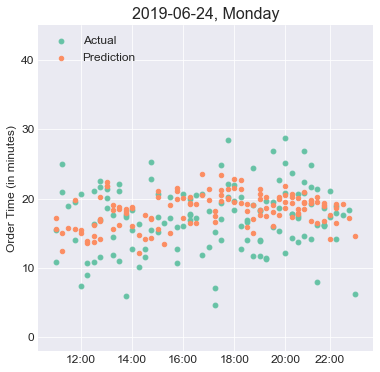

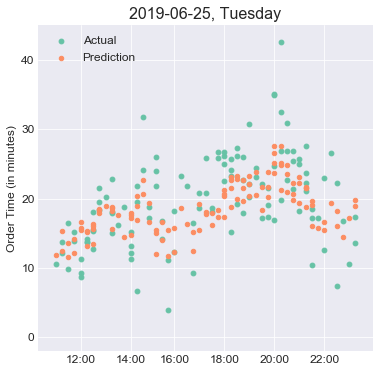

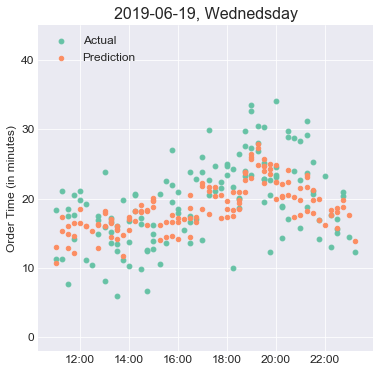

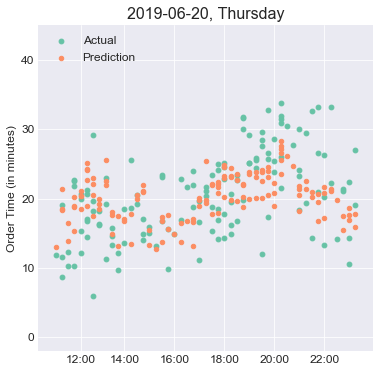

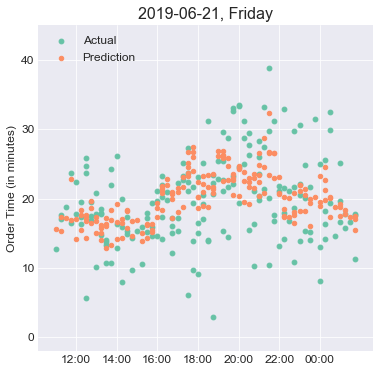

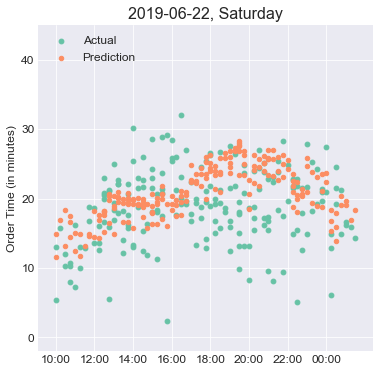

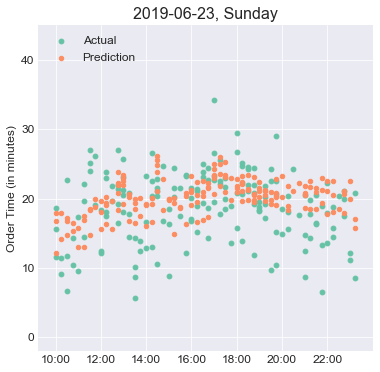

In [52]:
# Visualize
w = ['Monday','Tuesday','Wednedsday','Thursday','Friday','Saturday','Sunday']
ot_data['OrderTime-Min'] = ot_data['OrderTime']/60
ot_data['pred-min'] =ot_data['pred']/60
ot_data['Label2'] = (ot_data['QuarterHour']%2==0)
for i in range(7):
    # style
    plt.style.use('seaborn-darkgrid')

    # create a color palette
    palette = plt.get_cmap('Set2')
    plt.figure(figsize=(6,6))
    d = ot_data[ot_data['DayOfWeek']==i].sort_values(by='QuarterHour')
    day = d['BusinessDate'].unique()[0].astype('str')[0:10]
    
    plt.scatter(d['StartTime'],d['OrderTime-Min'], color=palette(0), label='Actual',s=23)
    plt.scatter(d['StartTime'],d['pred-min'], color=palette(1), label='Prediction',s=20)
    plt.xticks(d['StartTime'][d['Label2']].unique())
    
    plt.title(str(day)+', '+w[i],fontsize=16)
    
    # Add legend
    plt.legend(loc=2,fontsize=12)
    plt.ylabel('Order Time (in minutes)',fontsize=12)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.ylim(-2,45)

In [53]:
d['BusinessDate'].unique()[0].astype('str')[0:10]

'2019-06-23'

### Forecast

In [49]:
time_forecast_min = 17.5
time_forecast_max = 18.5
party_size = 2
c = 0
h = 0
#forecast = forecast[forecast['DayQuarterHour']==time_forecast] 

offsite = data[(data['Holiday']==h)&(data['Class']==c)&(data['QuarterHour']>=time_forecast_min)&(data['QuarterHour']<=time_forecast_min)].groupby('QuarterHour').agg({'OffSiteOrder':'mean','OffSiteItem':'mean'})
r = float(offsite['OffSiteItem'] / offsite['OffSiteOrder'])
del offsite

offsite1 = pd.DataFrame([[i,(i*r)] for i in range(0,32,1)],columns=['OffSiteOrder','OffSiteItem'])
offsite5 = pd.DataFrame([[i,(i*5)] for i in range(0,32,1)],columns=['OffSiteOrder','OffSiteItem'])
#offsite10 = pd.DataFrame([[i,(i*10)] for i in range(0,25,1)],columns=['OffSiteOrder','OffSiteItem'])

#var = ['OrderTime','DayOfWeek','QuarterHour','OffSiteOrder','OnSiteOrder','OnSiteItem','OffSiteItem','GuestCount','Class','OnSiteGuest']+labor_cat+labor_st

var_remove1 = ['OffSiteOrder','OffSiteItem']
#forecast_data = data[(data['DayQuarterHour']==(pd.to_datetime(time_forecast)-pd.to_timedelta(7,unit='day')))|\
#                    (data['DayQuarterHour']==(pd.to_datetime(time_forecast)-pd.to_timedelta(14,unit='day')))].groupby('DayQuarterHour')[var].mean()
forecast_data = data[(data['Class']==c)&(data['Holiday']==h)&(data['QuarterHour']<=time_forecast_max)&(data['QuarterHour']>=time_forecast_min)&(data['GuestCount']==party_size)][var].groupby('Class').median().reset_index()
forecast_data['Class'] = forecast_data['Class']+1

In [48]:
time_forecast_min = 18.5
time_forecast_max = 19
party_size = 2
h = 1
#forecast = forecast[forecast['DayQuarterHour']==time_forecast] 

offsite = data[(data['Holiday']==h)&(data['QuarterHour']>=time_forecast_min)&(data['QuarterHour']<=time_forecast_min)].groupby('QuarterHour').agg({'OffSiteOrder':'mean','OffSiteItem':'mean'})
r = float(offsite['OffSiteItem'] / offsite['OffSiteOrder'])
del offsite

offsite1 = pd.DataFrame([[i,(i*r)] for i in range(0,32,1)],columns=['OffSiteOrder','OffSiteItem'])
offsite5 = pd.DataFrame([[i,(i*5)] for i in range(0,32,1)],columns=['OffSiteOrder','OffSiteItem'])
#offsite10 = pd.DataFrame([[i,(i*10)] for i in range(0,25,1)],columns=['OffSiteOrder','OffSiteItem'])

#var = ['OrderTime','DayOfWeek','QuarterHour','OffSiteOrder','OnSiteOrder','OnSiteItem','OffSiteItem','GuestCount','Class','OnSiteGuest']+labor_cat+labor_st

var_remove1 = ['OffSiteOrder','OffSiteItem']
#forecast_data = data[(data['DayQuarterHour']==(pd.to_datetime(time_forecast)-pd.to_timedelta(7,unit='day')))|\
#                    (data['DayQuarterHour']==(pd.to_datetime(time_forecast)-pd.to_timedelta(14,unit='day')))].groupby('DayQuarterHour')[var].mean()
forecast_data = data[(data['Holiday']==h)&(data['QuarterHour']<=time_forecast_max)&(data['QuarterHour']>=time_forecast_min)&(data['GuestCount']==party_size)][var].groupby('Holiday').median().reset_index()
forecast_data['Class'] = 0

In [311]:
forecast_data.transpose()

,0
Class,1.00
OrderTime,1397.95
DayOfWeek,5.00
QuarterHour,18.00
OffSiteOrder,8.00
OnSiteOrder,25.00
OnSiteItem,58.00
OffSiteItem,17.00
GuestCount,2.00
OnSiteGuest,180.00


In [50]:
forecast_data1 = forecast_data.loc[forecast_data.index.repeat(len(offsite1))].reset_index(drop=True)
forecast_data1['OffSiteOrder'] = list(offsite1['OffSiteOrder'])
forecast_data1['OffSiteItem'] = list(offsite1['OffSiteItem'])
forecast_data1['GuestCount'] = party_size
forecast_reg1 = forecast_data1[reg_X.columns]
forecast_reg1_trans = scaler.transform(forecast_reg1)

forecast_data5 = forecast_data.loc[forecast_data.index.repeat(len(offsite5))].reset_index(drop=True)
forecast_data5['OffSiteOrder'] = list(offsite5['OffSiteOrder'])
forecast_data5['OffSiteItem'] = list(offsite5['OffSiteItem'])
forecast_data5['GuestCount'] = party_size
forecast_reg5 = forecast_data5[reg_X.columns]
forecast_reg5_trans = scaler.transform(forecast_reg5)


In [51]:
#Use Nueral Nets
forecast_data1['pred'] = nn.predict(forecast_reg1_trans)
forecast_data1['pred-min'] =forecast_data1['pred']/60

forecast_data5['pred'] = nn.predict(forecast_reg5_trans)
forecast_data5['pred-min'] =forecast_data5['pred']/60

In [179]:
#Use Gradient Boosting
forecast_data1['pred'] = gb.predict(forecast_reg1_trans)
forecast_data1['pred-min'] =forecast_data1['pred']/60

NameError: name 'gb' is not defined

Text(0,0.5,'Order Time (in minutes)')

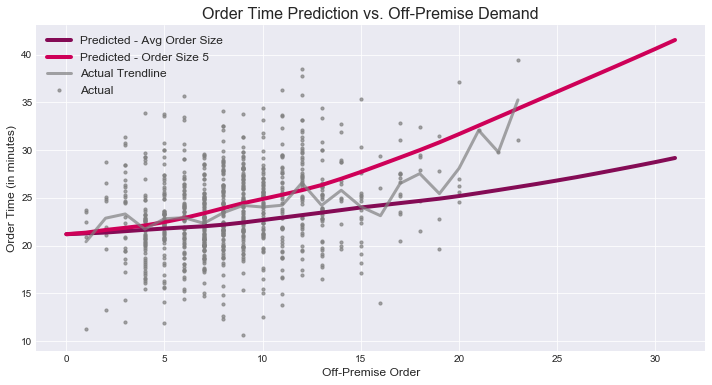

In [61]:
plt.style.use('seaborn-darkgrid')
forecast_data['OrderTime-Min'] = forecast_data['OrderTime']/60

d = data[(data['Class']==c)&(data['QuarterHour']>=time_forecast_min)&(data['QuarterHour']<=time_forecast_max)&(data['GuestCount']==party_size)]
# create a color palette
palette = plt.get_cmap('Set2')
plt.figure(figsize=(12,6))


plt.plot(forecast_data1['OffSiteOrder'],forecast_data1['pred-min'], color='#840b55', linewidth = 4,label='Predicted - Avg Order Size')
plt.plot(forecast_data5['OffSiteOrder'],forecast_data5['pred-min'], color='#CE0058', linewidth = 4,label='Predicted - Order Size 5')

plt.scatter(d['OffSiteOrder'],d['OrderTime']/60,s=10,alpha = 0.7,color='grey',label='Actual')
plt.plot(d.groupby(['OffSiteOrder'])['OrderTime'].mean()/60,color='grey',alpha = 0.7,linewidth=3,label='Actual Trendline')

plt.title('Order Time Prediction vs. Off-Premise Demand',fontsize=16)

# Add legend
plt.legend(loc=2,fontsize=12) 
plt.xlabel('Off-Premise Order',fontsize=12)
plt.ylabel('Order Time (in minutes)',fontsize=12)
#plt.xlim(-1,40)
#plt.ylim(4,33)

Text(0,0.5,'Order Time (in minutes)')

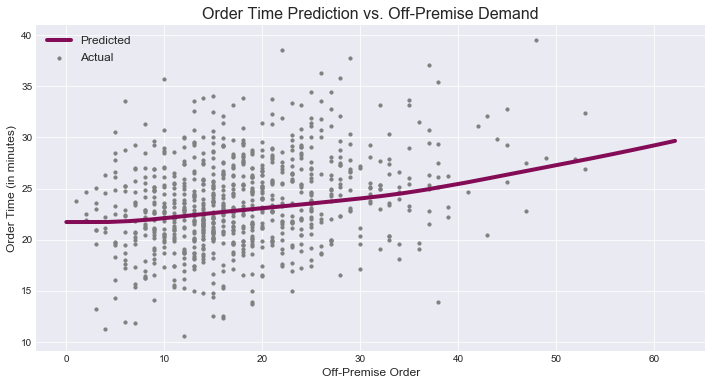

In [155]:
plt.style.use('seaborn-darkgrid')
forecast_data['OrderTime-Min'] = forecast_data['OrderTime']/60
forecast_data1['pred-min'] =forecast_data1['pred']/60

d = data[(data['Class']==c)&(data['QuarterHour']>=time_forecast_min)&(data['QuarterHour']<=time_forecast_max)&(data['GuestCount']==party_size)]
# create a color palette
palette = plt.get_cmap('Set2')
plt.figure(figsize=(12,6))

plt.plot(forecast_data1['OffSiteItem'],forecast_data1['pred-min'], color='#840b55', linewidth = 4,label='Predicted')
plt.scatter(d['OffSiteItem'],d['OrderTime']/60,s=10,color='grey',label='Actual')

plt.title('Order Time Prediction vs. Off-Premise Demand',fontsize=16)

# Add legend
plt.legend(loc=2,fontsize=12) 
plt.xlabel('Off-Premise Order',fontsize=12)
plt.ylabel('Order Time (in minutes)',fontsize=12)
#plt.xlim(-1,40)
#plt.ylim(4,33)